0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.692439734104322
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


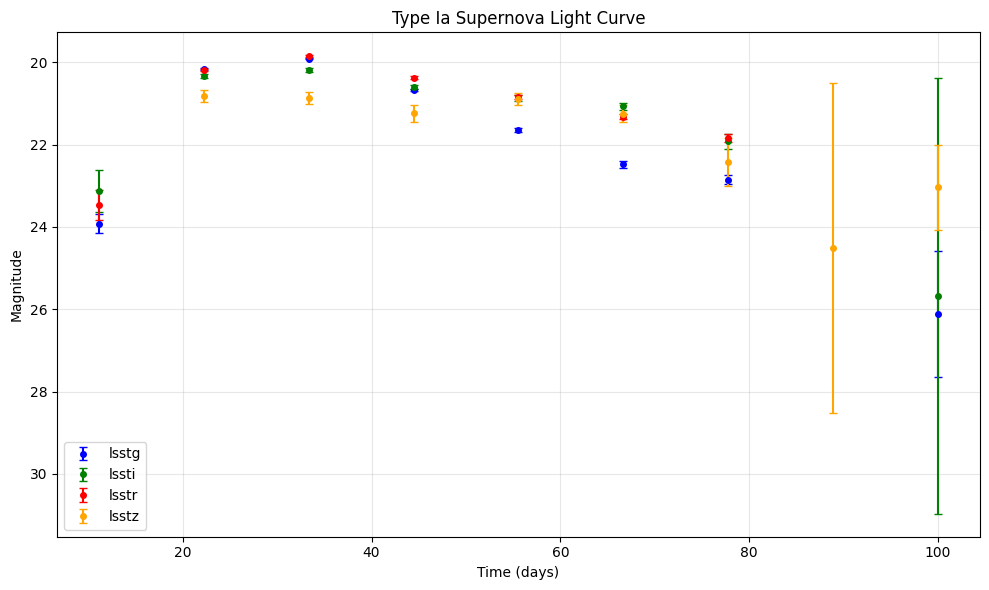

In [18]:
import numpy as np
import sncosmo
from astropy.table import Table
import matplotlib.pyplot as plt

times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    r_band_mask = lcs[0]['band'] == 'lsstr'
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    return result, fitted_model

def plot_light_curve(lc):
    """
    Plot the light curve in different bands
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique bands
    bands = np.unique(lc['band'])
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, band in enumerate(bands):
        mask = lc['band'] == band
        time = lc['time'][mask]
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        
        # Convert flux to magnitude
        mag = -2.5 * np.log10(flux) + lc['zp'][mask]
        magerr = np.abs(2.5 / np.log(10) * fluxerr / flux)
        
        ax.errorbar(time, mag, yerr=magerr, fmt='o', 
                   label=f'{band}', color=colors[i % len(colors)], 
                   capsize=3, markersize=4)
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Type Ia Supernova Light Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Brighter objects have lower magnitudes
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to simulate a Type Ia supernova and fit its light curve
    """
    # Define supernova parameters
    true_z = 0.1  # redshift
    t0 = 30.0      # time of maximum brightness
    mb = 20.0    # absolute B-band magnitude
    x0 = get_x0(mb)  # amplitude parameter
    x1 = 0.5      # stretch parameter
    c = 0.0       # color parameter
    print(x0)
    
    print(f"Simulating Type Ia supernova with:")
    print(f"  Redshift (z): {true_z}")
    print(f"  Absolute B magnitude: {mb}")
    print(f"  Stretch (x1): {x1}")
    print(f"  Color (c): {c}")
    print(f"  Amplitude (x0): {x0:.6f}")
    print()
    
    # Simulate the light curve
    print("Simulating light curve...")
    lcs = simulate_ia(true_z, t0, x0, x1, c)
    
    # Plot the light curve
    print("Plotting light curve...")
    plot_light_curve(lcs[0])
    
    return lcs

if __name__ == "__main__":
    lcs = main()

0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.400036690280416
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


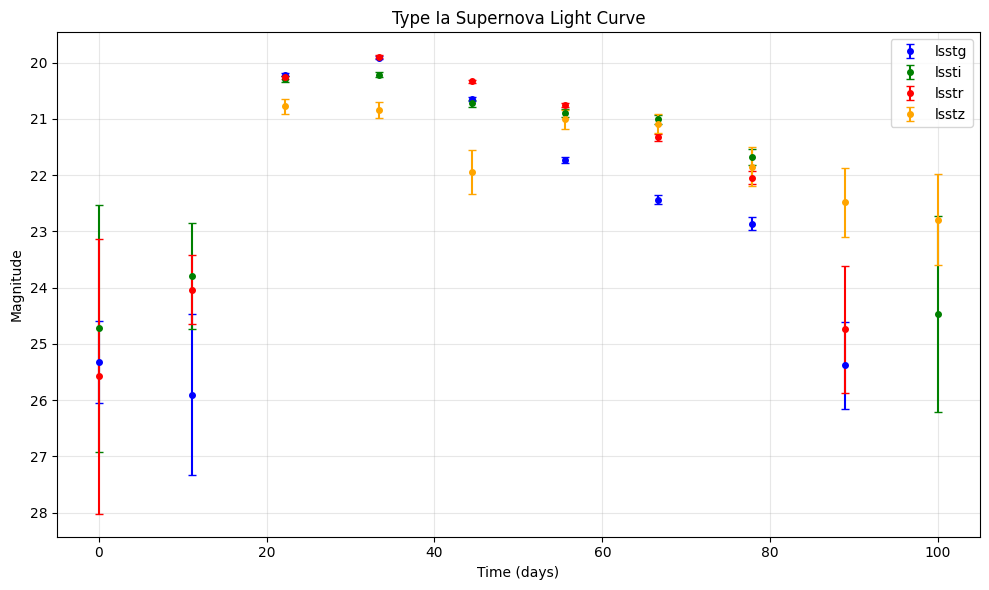

In [19]:
lcs = main()

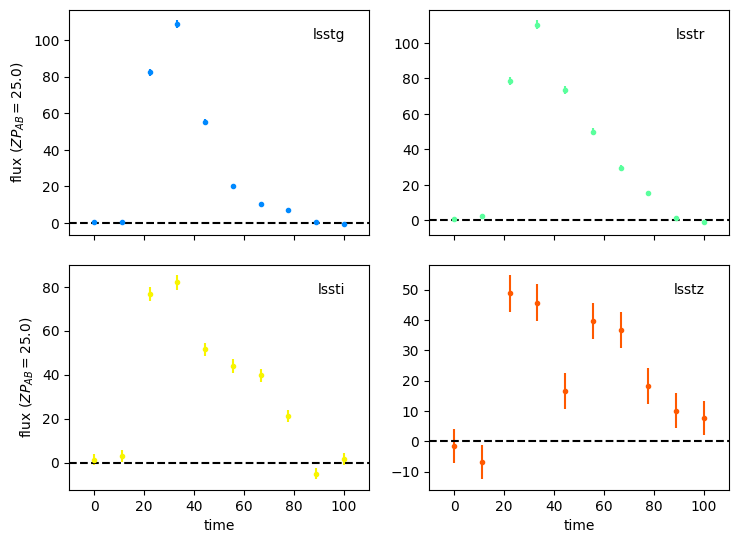

In [20]:
sncosmo.plot_lc(lcs[0]);

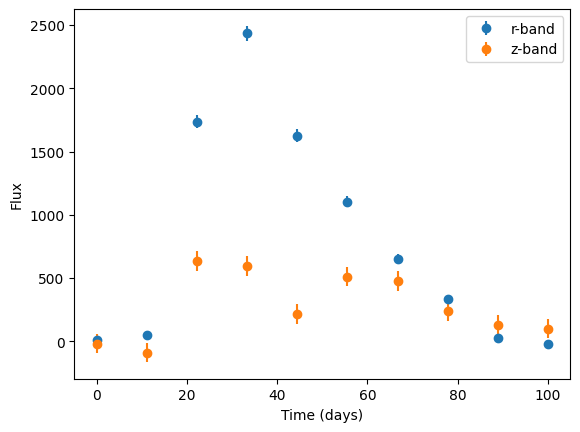

In [21]:
r_band_mask = lcs[0]['band'] == 'lsstr'
z_band_mask = lcs[0]['band'] == 'lsstz'


plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask], yerr=lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask], yerr=lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

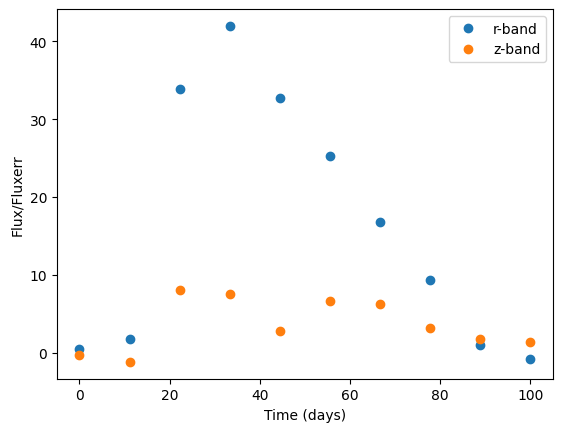

In [23]:
plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask]/lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask]/lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux/Fluxerr')
plt.legend()
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [25]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [26]:
data = np.load("fitted_sne_100_091725.npz", allow_pickle=True)
true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne)


(100, 200)

In [27]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

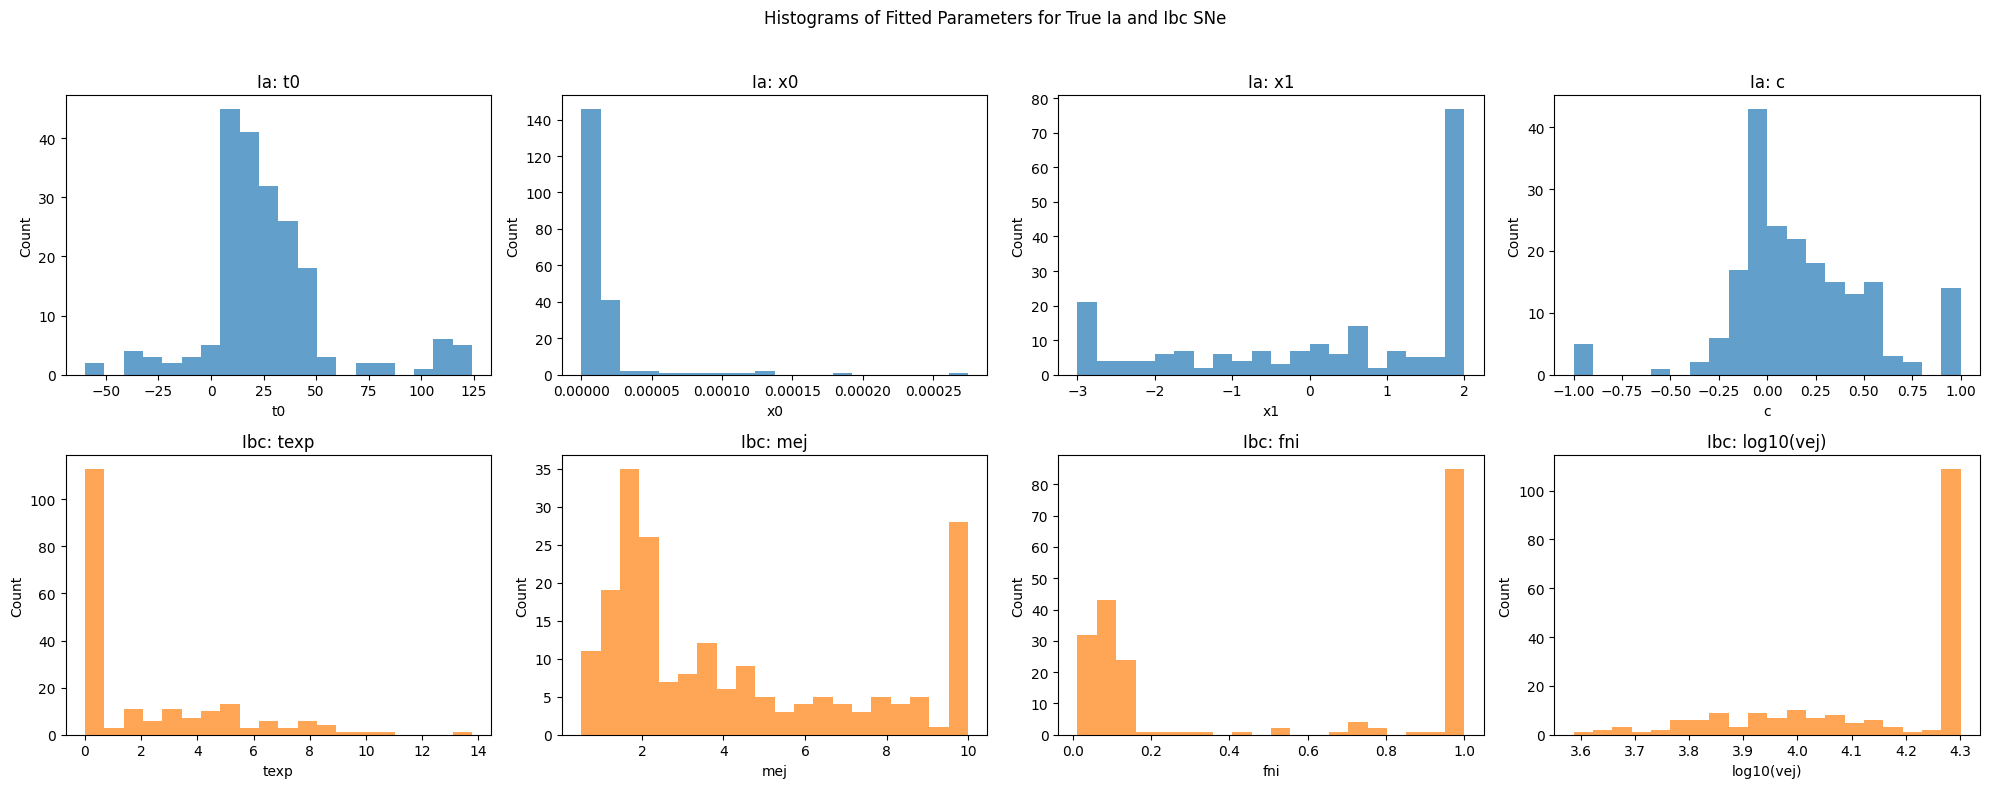

In [28]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

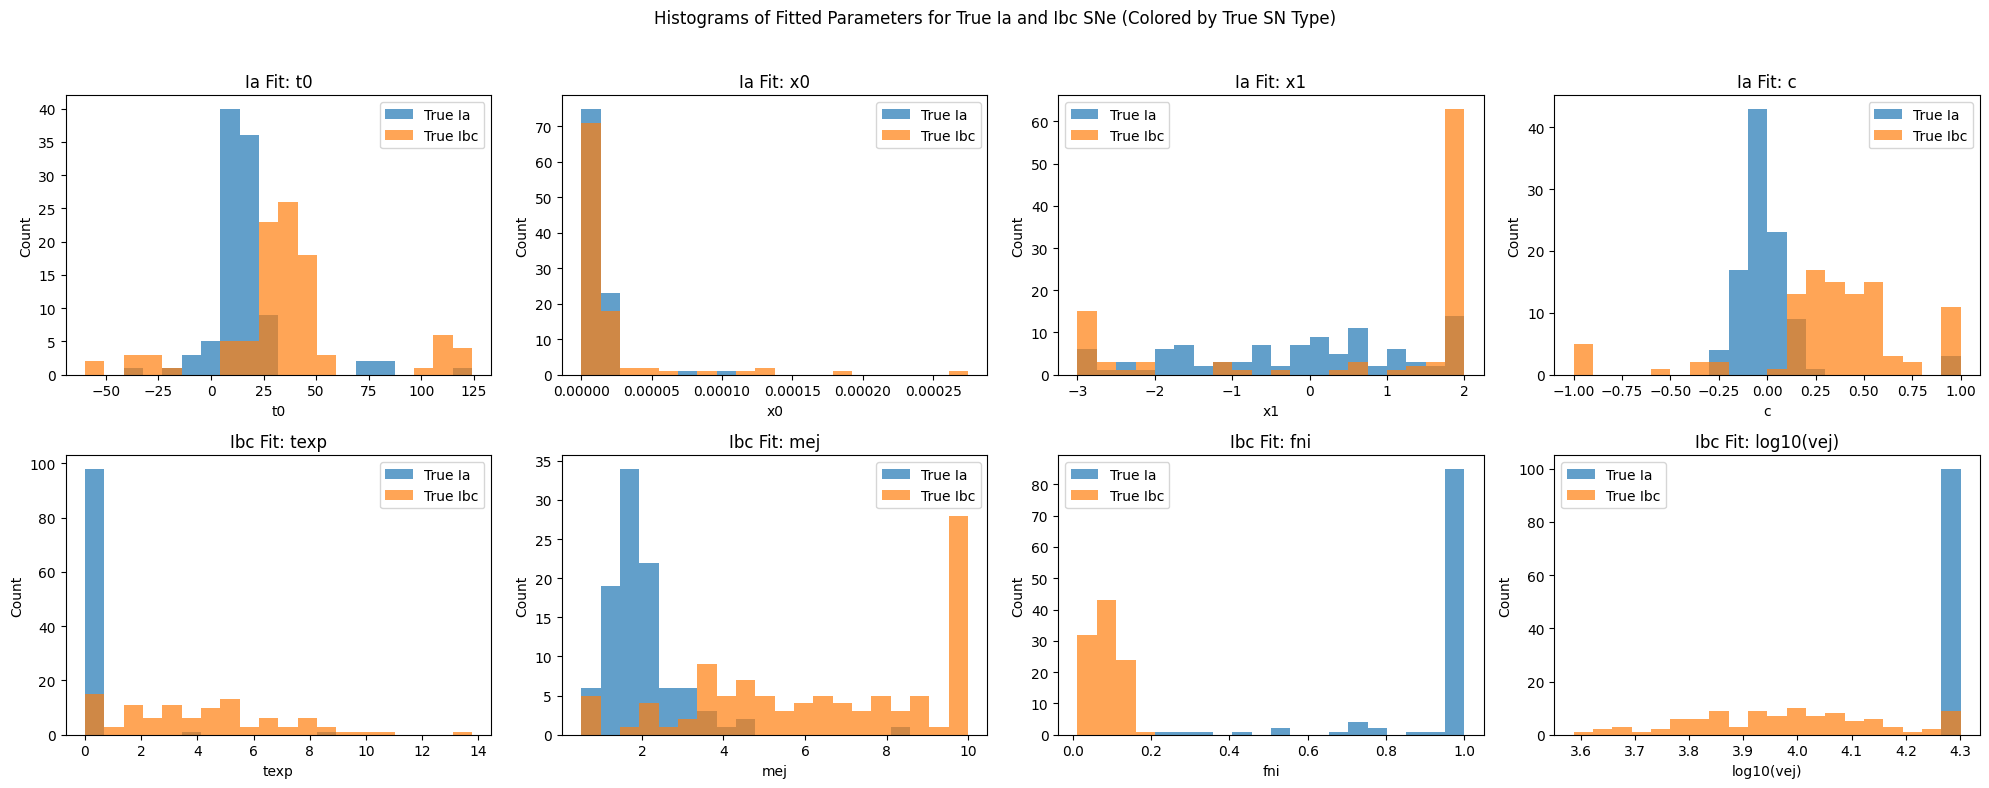

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    axes[0, i].set_title(f"Ia Fit: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'vej':
        axes[1, i].set_title(f"Ibc Fit: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].set_title(f"Ibc Fit: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [30]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [31]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([187.,   4.,   2.,   2.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([1.09204827e-14, 2.74918796e-05, 5.49837591e-05, 8.24756387e-05,
        1.09967518e-04, 1.37459398e-04, 1.64951277e-04, 1.92443157e-04,
        2.19935036e-04, 2.47426916e-04, 2.74918796e-04]),
 <BarContainer object of 10 artists>)

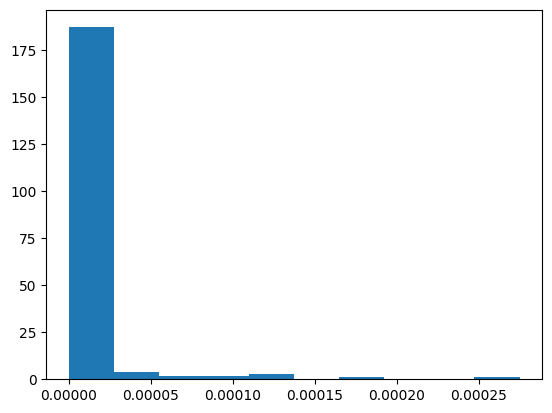

In [87]:
plt.hist(get_param_samples('x0'))

In [33]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(200, 1)

In [34]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_)

t0 [0.05982656 0.94017344]
c [0.74855886 0.25144114]
mej [0.3103879 0.6896121]
texp [0.54496323 0.45503677]
x1 [0.67011857 0.32988143]
x0 [0.97033783 0.02966217]
fni [0.51483883 0.48516117]
log_vej [0.53978845 0.46021155]


In [35]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[-0.56452767],
        [ 1.99998766]]),
 array([[[1.61706340e+00]],
 
        [[1.00297117e-03]]]),
 array([0.67011857, 0.32988143]))

In [48]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.3474294712530701
Alpha 0.42334846193824527
Alpha 0.44671083076769624
Alpha 0.45342213846304974
Alpha 0.45501741611028634
Alpha 0.45695972709682076
Alpha 0.4800114101617109
Alpha 0.5026736910497965
Alpha 0.509163506207978
Alpha 0.5118977589124889
Alpha 0.5138404253001962
Alpha 0.5149312801855527
Alpha 0.5158136181890152
Alpha 0.5165499691953506
Alpha 0.5171645798600246
Alpha 0.5176756800791161
Alpha 0.5181001302616288
Alpha 0.5184533089183316
Alpha 0.5187485824539396
Alpha 0.5189970951156552
Alpha 0.5192078656454298
Alpha 0.5193880541130312
Alpha 0.5195432856572302
Alpha 0.5196779637276523
Alpha 0.5197955417293505
Alpha 0.5198987442080334
Alpha 0.519989740076821
Alpha 0.5200702750054667
Alpha 0.5201417711003485
Alpha 0.5202054013462523
Alpha 0.5202621450301725
Alpha 0.5203128290472346
Alpha 0.5203581588196016
Alpha 0.5203987416083092
Alpha 0.5204351042598634
Alpha 0.5204677068737303
Alpha 0.5204969534672922
Alpha 0.5205232004155189
Alpha 0.5205467632270587
Alpha 0.52056792206317

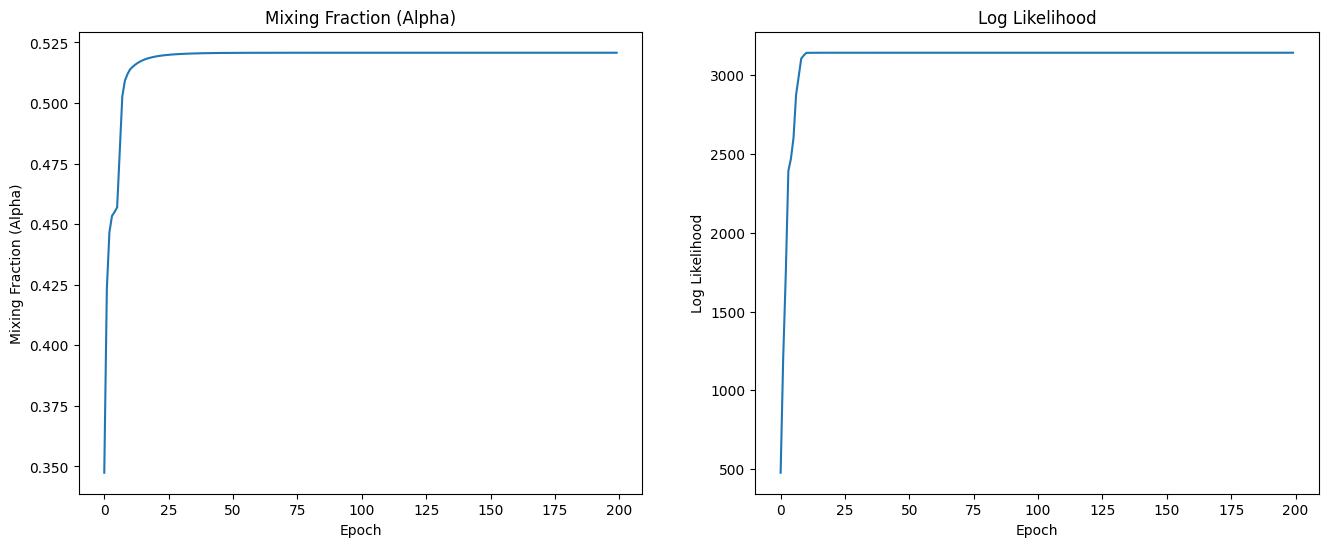

In [49]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [77]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 115.09961176102141,
  'c': 0.035606355121832516,
  'mej': 6.486908884599663,
  'texp': 2.117704693027632e-06,
  'x1': -0.5088065308220957,
  'x0': 1.11364358462347e-05,
  'fni': 0.08566786960045544,
  'log_vej': 4.301029903860852},
 {'t0': 20.59366623399123,
  'c': 0.2961140878266591,
  'mej': 1.719131302680311,
  'texp': 4.210135806486797,
  'x1': 1.999998651503344,
  'x0': 4.6560258550489816e-05,
  'fni': 0.9572321422448714,
  'log_vej': 3.958494904374303},
 {'t0': 5.802497007754456,
  'c': 0.15358166382989444,
  'mej': 2.7691570481353254,
  'texp': 0.01,
  'x1': 1.6425139470616115,
  'x0': 0.01,
  'fni': 0.04478385720691753,
  'log_vej': 0.01},
 {'t0': 21.0699768681291,
  'c': 0.4661155898637257,
  'mej': 0.5720916509212276,
  'texp': 2.720762734673538,
  'x1': 0.01,
  'x0': 0.01,
  'fni': 0.12217080611842712,
  'log_vej': 0.15283995180483184})

In [69]:
for n in sigmas_b.keys():
    if sigmas_b[n] <= 0.01:
        sigmas_b[n] = 0.01

for n in sigmas_a.keys():
    if sigmas_a[n] <= 0.01:
        sigmas_a[n] = 0.01

[20.6692146  20.67130471 20.67337415 20.67542291 20.67745099 20.67945838
 20.68144508 20.68341107 20.68535636 20.68728093 20.68918479 20.69106792
 20.69293032 20.69477199 20.69659291 20.69839309 20.70017252 20.70193119
 20.70366909 20.70538623 20.70708259 20.70875818 20.71041298 20.71204699
 20.71366021 20.71525264 20.71682425 20.71837507 20.71990506 20.72141424
 20.7229026  20.72437014 20.72581684 20.72724271 20.72864773 20.73003192
 20.73139525 20.73273774 20.73405937 20.73536013 20.73664004 20.73789907
 20.73913724 20.74035453 20.74155094 20.74272647 20.74388111 20.74501486
 20.74612772 20.74721968 20.74829074 20.7493409  20.75037015 20.75137849
 20.75236592 20.75333244 20.75427804 20.75520271 20.75610646 20.75698929
 20.75785118 20.75869214 20.75951217 20.76031126 20.76108942 20.76184662
 20.76258289 20.76329821 20.76399258 20.764666   20.76531847 20.76594998
 20.76656054 20.76715013 20.76771877 20.76826645 20.76879316 20.76929891
 20.76978368 20.7702475  20.77069034 20.77111221 20

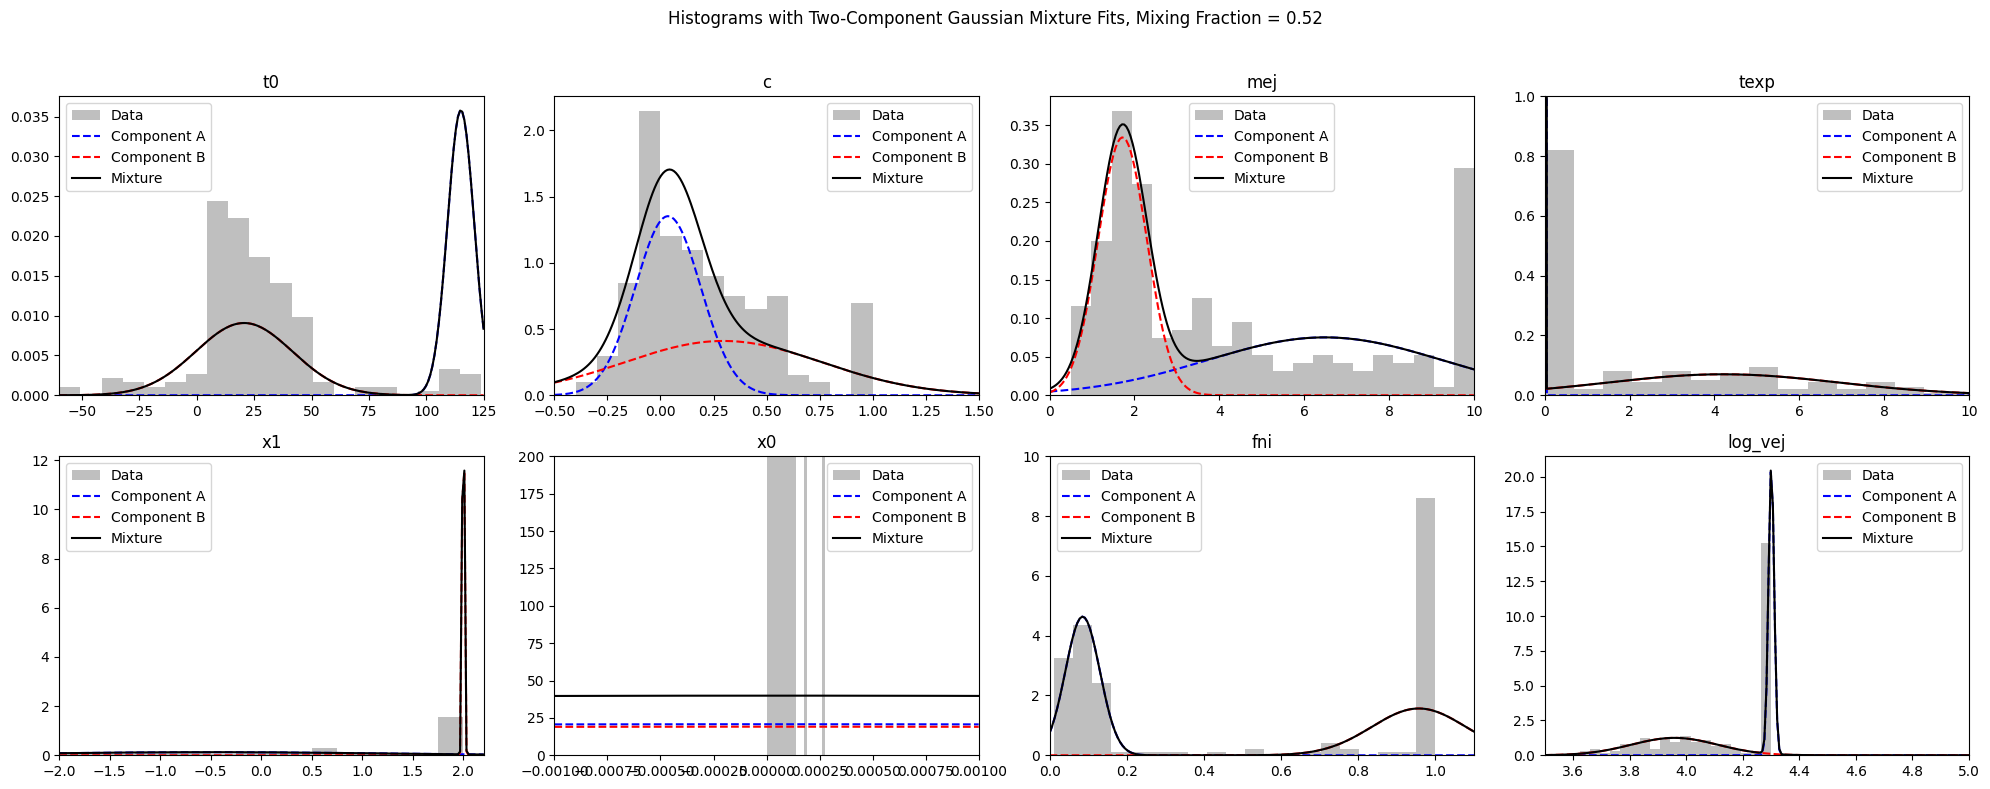

In [90]:
x_ranges = {
    't0': np.linspace(-60, 125, 200),
    'x0': np.linspace(-0.001, 0.001, 200),  # Expanded range for x0
    'x1': np.linspace(-2, 2.2, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(0, 10, 200),
    'mej': np.linspace(0, 10, 200),
    'fni': np.linspace(0, 1.3, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms with Two-Component Gaussian Mixture Fits, Mixing Fraction = {:.2f}".format(alpha))

for idx, param in enumerate(params_to_use):
    samples = get_param_samples(param)
    ax = axes.flat[idx]
    ax.hist(samples, bins=20, density=True, alpha=0.5, color='gray', label='Data')
    x = x_ranges[param]
    # Mixture fit
    y_a = alpha * norm.pdf(x, mus_a[param], sigmas_a[param])
    y_b = (1 - alpha) * norm.pdf(x, mus_b[param], sigmas_b[param])
    y_mix = y_a + y_b
    if param == 'x0':
        print(y_a)
    ax.plot(x, y_a, 'b--', label='Component A')
    ax.plot(x, y_b, 'r--', label='Component B')
    ax.plot(x, y_mix, 'k-', label='Mixture')
    ax.set_title(param)
    ax.set_xlim(x[0], x[-1])  # Ensure curves span the full x range
    if param == 'texp':
        ax.set_ylim(0, 1)
    elif param == 'fni':
        ax.set_ylim(0, 10)
        ax.set_xlim(0, 1.1)
    elif param == 'x0':
        ax.set_ylim(0, 200)
        ax.set_xlim(-0.001, 0.001)  # Expanded
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(array([187.,   4.,   2.,   2.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([1.09204827e-14, 2.74918796e-05, 5.49837591e-05, 8.24756387e-05,
        1.09967518e-04, 1.37459398e-04, 1.64951277e-04, 1.92443157e-04,
        2.19935036e-04, 2.47426916e-04, 2.74918796e-04]),
 <BarContainer object of 10 artists>)

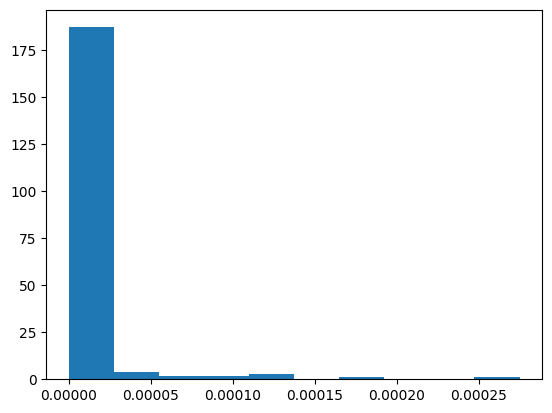

In [91]:
plt.hist(get_param_samples('x0'))